# Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

(Please make sure to first read the file called "README.md". It helps to get the main story line of what we did and the organization of the files.)

Let's maybe first remember here the research questions of this project:

## **Main Research Question**:

"How can the reliability and efficiency of Kotug OptiPort's tugboat scheduling tool be enhanced through the development and evaluation of novel methods for predicting pickup and drop-off coordinates and other relevant variables?"

## **Subresearch Questions**:

- "What advanced predictive methods can be developed and implemented to accurately forecast the coordinates (latitude and longitude) for pickup and drop-off locations of tugs on vessels in the port of Rotterdam?"
- "Which variables, including AIS data, customer requirements, and port-specific constraints (or lack thereof), play a significant role in determining the pickup and drop-off locations and timing of tugs, as well as the required number of tugs for each vessel operation in the port of Rotterdam, and why are they important?"
- "Which of the above mentioned variables can be combined in order to increase the reliability of the results, and why can they be combined?"

The work on this first research question in done in this file, while the 2 other subquestions are answered in the file called "Data_preparation". Finally, this file also contains the conclusion of this project (see end of the file).


# Predictions

Literature review that explains the path followed through the different methods used:

As part of our effort to answer the first research question and to identify appropriate techniques for geospatial data processing, we painstakingly carried out a literature research. There were two goals in mind: finding viable approaches and understanding how they may be used in the field. Our investigation produced important findings that shaped our methodology. The key findings were the following:
1. Integrated prediction over isolated coordinates: We could have been tempted at first to use several regression models to predict latitude and longitude independently. The literature, however, strongly advises against this practise. Researchers and academics often advise against this segmentation. This advice is supported by the fact that latitude and longitude have complex interactions that are difficult to fully comprehend when viewed as separate concepts. As a result, we began to concentrate on holistic approaches that take into account all of these factors at once.
2. The potential of decision tree classifiers on our discretized polygon of water: Among the methods for classifying our data that showed promise was the decision tree classifier, especially when it came to pick-up and drop-off location prediction. It is not without restrictions, despite its potential. Indeed, we could use it, however we should create a dependence between squares (notable squares that are close to each other as an example). This could be done via new variables that we do not have. Developping them would be too complicated to apply in this project. Furthermore, its failure to adequately incorporate the geospatial nuances of our scenario is a major limitation. This insight drove us to read more in the literature and look for techniques that include the geographical dimension from the beginning. However, you can still see the results from this first method below.  
3.  Introducing kriging, a spatial regression method: Our research introduced us to the Kriging technique, which is a very relevant method for our needs regarding the classification of geospatial data. This could be done on our discretized polygon of water. Furthermore, it is a reliable framework for position prediction that takes into consideration the underlying spatial patterns. Using the spatial correlations found in our data, this approach solves our categorization problem in a way that is contextually rich and nuanced. Unfortunately, after reading a lot about it, we again remarked that this method asks for a lot of complicated work before applying the method. We do not have the knowledges now to handle it in a way that allows us to produce convincing results. Thus, we decided to search for further possible methods.
4. We reached the consensus that it's essential to reconsider approaches that don't rely on our discretized polygon. This broader perspective ensures we're not confined by our initial decision to go for this polygon. Following a brainstorming session and further reading of papers, we determined that ...... TO BE COMPLETED


## Import the required librairies

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import seaborn as sn

import folium
import rasterio
import rasterio.mask

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium

from shapely.geometry import Point, Polygon, LineString
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from pyproj import Geod

## Import raw data

In [2]:
incoming_weather_size_draught = gpd.read_file('Data/Input_ML/incoming_weather_size_draught.geojson')
incoming_weather_size = gpd.read_file('Data/Input_ML/incoming_weather_size.geojson')
incoming_weather = gpd.read_file('Data/Input_ML/incoming_weather.geojson')

In [3]:
havens = list(incoming_weather_size_draught['to_haven'].unique())

In [4]:
incoming_weather_size.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5466 entries, 0 to 5465
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              5466 non-null   int64              
 1   center               5466 non-null   object             
 2   from                 5466 non-null   object             
 3   from_rounded         5466 non-null   datetime64[ns, UTC]
 4   to_haven             5466 non-null   object             
 5   trip_ID              5466 non-null   int64              
 6   vessel_mmsi          5466 non-null   int64              
 7   area                 5466 non-null   object             
 8   Wind_Direction_Cat1  5466 non-null   object             
 9   Wind_Direction_Cat2  5466 non-null   object             
 10  Wind_Speed           5466 non-null   int64              
 11  distance             5466 non-null   float64            
 12  Wind_Directi

In [5]:
leaving_weather_size_draught = gpd.read_file('Data/Input_ML/leaving_weather_size_draught.geojson')
leaving_weather_size = gpd.read_file('Data/Input_ML/leaving_weather_size.geojson')
leaving_weather = gpd.read_file('Data/Input_ML/leaving_weather.geojson')

In [6]:
leaving_weather_size_draught.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   area_ID              2302 non-null   int64              
 1   center               2302 non-null   object             
 2   to                   2302 non-null   object             
 3   to_rounded           2302 non-null   datetime64[ns, UTC]
 4   from_haven           2302 non-null   object             
 5   trip_ID              2302 non-null   int64              
 6   vessel_mmsi          2302 non-null   int64              
 7   area                 2302 non-null   object             
 8   Wind_Direction_Cat1  2302 non-null   object             
 9   Wind_Direction_Cat2  2302 non-null   object             
 10  Wind_Speed           2302 non-null   int64              
 11  distance             2302 non-null   float64            
 12  Wind_Directi

# **Trajectories approach**

In [7]:
# Columns that will be used for the predictions
columns_leaving_trajectories = [
    'from_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Type_Cat',
    'distance'
]

columns_incoming_trajectories = [
    'to_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Type_Cat',
    'distance'
]

Random Forest Regressor is an ensemble learning method based on the decision tree algorithm. It operates by constructing multiple decision trees during training and outputs the average prediction of the individual trees for regression tasks. In the context of assigning pick-up and drop-off locations to vessels following a trajectory, using a Random Forest Regressor offers several advantages:
1. Handling non-linearity: The random forest method can capture complex, nonlinear relationships in the data, making them suitable for predicting pick-up and drop-off locations;
2. Ensemble learning: Random Forest is an ensemble learning technique, meaning it combines predictions from multiple individual decision trees. This ensemble approach often leads to more accurate and stable predictions compared to a single decision tree. 
3. Robustness to Overfitting: Random Forests are inherently resistant to overfitting, a common challenge in complex modeling tasks. By aggregating predictions from multiple trees, it tends to generalize better to unseen data, ensuring robust and reliable predictions for vessel locations.
4. Feature importance: this method provides a natural way to rank the importance of input features. Understanding which variables significantly influence pick-up and drop-off locations is crucial for decision-making.
5. Handling multiple variables: Random Forests can handle diverse types of data, including numerical and categorical variables. 
6. Outlier resistance: This method is less sensitive to outliers due to the averaging effect from multiple trees.

## Prediction for LEAVING

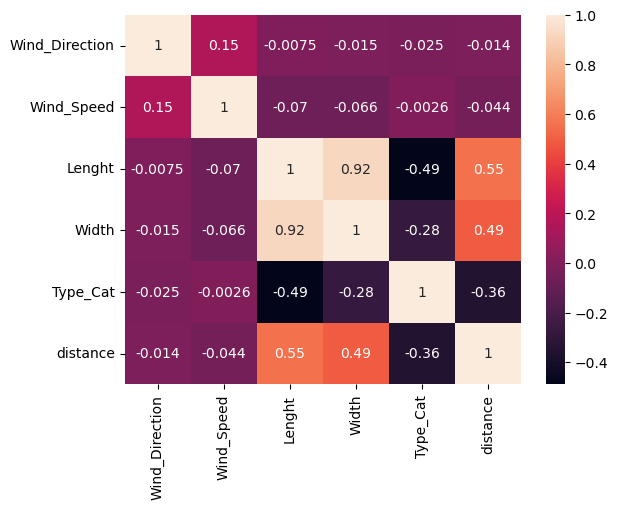

In [8]:
corr_matrix_incoming = incoming_weather_size_draught[columns_incoming_trajectories]
corr_matrix_incoming = corr_matrix_incoming.drop(columns = 'to_haven').corr()
sn.heatmap(corr_matrix_incoming, annot=True)
plt.show()

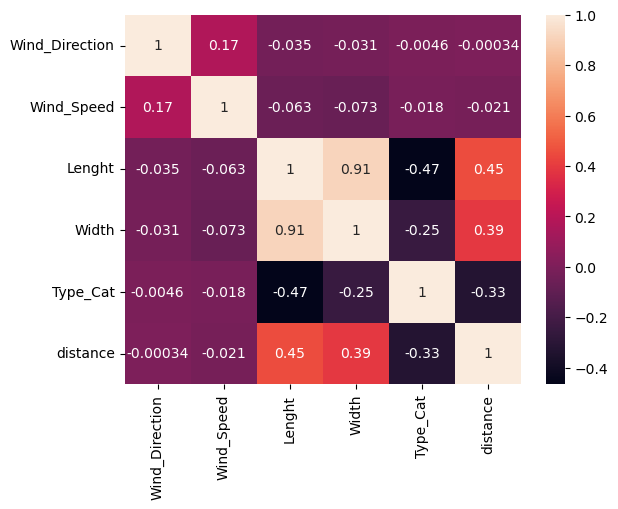

In [9]:
corr_matrix_leaving = leaving_weather_size_draught[columns_leaving_trajectories]
corr_matrix_leaving = corr_matrix_leaving.drop(columns = 'from_haven').corr()
sn.heatmap(corr_matrix_leaving, annot=True)
plt.show()

## Random forests

In [10]:
def Random_forest(grouped_df, haven):
    haven_df = grouped_df.loc[haven]

    X = haven_df.drop(columns= 'distance')
    y = haven_df['distance'] 

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)

    # Add the predicted distances to the original DataFrame
    X_test['predicted_distance'] = y_pred

    X_test['original_distance'] = haven_df['distance'].loc[list(X_test.index.values)]
    X_test['diff_dist'] = abs(X_test['predicted_distance']  - X_test['original_distance'])
    
    average_diff = X_test['diff_dist'].mean()

    values = [average_diff]
    columns = ['avg_diff']

    # You can also access feature importances
    feature_importances = rf_model.feature_importances_.tolist()

    values.extend(feature_importances)
    columns.extend(X.columns)

    values.extend([haven])
    columns.extend(['haven'])

    output = pd.DataFrame([values], columns=columns)

    return output, X_test



In [11]:
incoming_trajectories = incoming_weather_size_draught[columns_incoming_trajectories]
incoming_per_haven = pd.DataFrame(incoming_trajectories['to_haven'].value_counts())
incoming_per_haven.reset_index(inplace=True)
incoming_trajectories = incoming_trajectories.groupby('to_haven').apply(lambda x: x).drop(columns = 'to_haven')

In [12]:
# Data frame to get an overview of the results and the feature importance
incoming_pred_forest = []
incoming_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(incoming_trajectories, haven)
    incoming_overall_avg.extend(list(pred['diff_dist']))
    incoming_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(incoming_overall_avg)/len(incoming_overall_avg), "meters")
incoming_pred_forest = pd.concat(incoming_pred_forest).reset_index(drop= True)

incoming_pred_forest = incoming_pred_forest.merge(incoming_per_haven[['to_haven','count']], left_on='haven', right_on='to_haven').drop(columns='to_haven')

incoming_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1061.32566005035 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,haven,count
3,906.792924,0.151884,0.186402,0.454030,0.185874,0.021809,EURO,480
7,1355.918671,0.170640,0.204958,0.405304,0.218365,0.000732,7PET,377
4,1362.284932,0.102057,0.163836,0.639117,0.093798,0.001193,AMALIA,311
6,1484.473503,0.188663,0.236212,0.367934,0.187889,0.019302,CKVTTI,309
2,601.848531,0.110604,0.162256,0.520682,0.206459,0.000000,AMAZ,271
5,1018.193132,0.075998,0.108886,0.505548,0.209288,0.100279,YANG,248
0,862.881700,0.227385,0.260955,0.321602,0.190059,0.000000,3PET,220
8,765.720238,0.208000,0.257794,0.248052,0.255186,0.030967,MISS,127
1,693.928421,0.287710,0.307554,0.271824,0.121173,0.011739,PET8,125
9,1078.859915,0.204859,0.161756,0.337341,0.264208,0.031835,WAAL,79


## Prediction for Leaving

In [13]:
leaving_trajectories = leaving_weather_size_draught[columns_leaving_trajectories]
leaving_per_haven = pd.DataFrame(leaving_trajectories['from_haven'].value_counts())
leaving_per_haven.reset_index(inplace=True)
leaving_trajectories = leaving_trajectories.groupby('from_haven').apply(lambda x: x).drop(columns = 'from_haven')

In [14]:
# Data frame to get an overview of the results and the feature importance
leaving_pred_forest = []
leaving_overall_avg = []
for haven in havens:
    avg_diff, pred = Random_forest(leaving_trajectories, haven)
    leaving_overall_avg.extend(list(pred['diff_dist']))
    leaving_pred_forest.append(avg_diff)

# Overall Average distance between predicted and real locations
print("Average distance between predicted and real locations: ", sum(leaving_overall_avg)/len(leaving_overall_avg), "meters")
leaving_pred_forest = pd.concat(leaving_pred_forest).reset_index(drop= True)

leaving_pred_forest = leaving_pred_forest.merge(leaving_per_haven[['from_haven','count']], left_on='haven', right_on='from_haven').drop(columns='from_haven')

leaving_pred_forest.sort_values(by = 'count', ascending = False)

Average distance between predicted and real locations:  1398.5136240203924 meters


,avg_diff,Wind_Direction,Wind_Speed,Lenght,Width,Type_Cat,haven,count
3,1069.156170,0.176026,0.214952,0.402552,0.189653,0.016817,EURO,451
4,1799.646562,0.135893,0.155416,0.579372,0.127391,0.001927,AMALIA,309
2,1156.304442,0.201644,0.246122,0.301242,0.244329,0.006662,AMAZ,282
7,1818.005708,0.209287,0.262015,0.294571,0.234127,0.000000,7PET,281
6,1765.591940,0.227474,0.234736,0.333767,0.183031,0.020991,CKVTTI,243
5,1124.968610,0.110069,0.148362,0.501031,0.218802,0.021736,YANG,233
0,1161.114317,0.240438,0.287152,0.282350,0.178669,0.011392,3PET,187
8,1486.861676,0.261083,0.300046,0.267561,0.149076,0.022234,MISS,131
1,797.233282,0.228904,0.321436,0.359369,0.088219,0.002072,PET8,106
9,2006.631295,0.123336,0.219798,0.367992,0.236057,0.052817,WAAL,79


# **Areas approach**

Given the variation in data availability across different harbors, this strategic approach was firstly adopted. We specifically targeted a single harbor for analysis. The flexibility of this model allows us to select any harbor for analysis simply by modifying a designated variable in the code. Opting for a specific harbor selection has the added advantage of narrowing down the relevant squares associated with the chosen harbor. This focused approach significantly reduces the number of squares considered in each case (only the squares that are relevant for each harbour), consequently decreasing the computational power required for the predictions.

To elaborate, we begin by choosing a harbor with substantial data volume. All relevant data pertaining to incoming and departing vessels from this selected harbor is extracted. Our model is then applied to this subset of data. Notably, the ability to change the harbor variable in the code grants the flexibility to extend this analysis to other harbors seamlessly.

In [14]:
# 2 most used harbour for the incoming and leaving vessels
leaving_top = leaving_weather_size_draught['from_haven'].value_counts()
incoming_top = incoming_weather_size_draught['to_haven'].value_counts()
print(leaving_top[0:2])
print(incoming_top[0:2])

from_haven
EURO      451
AMALIA    309
Name: count, dtype: int64
to_haven
EURO    480
7PET    377
Name: count, dtype: int64


In [15]:
# Selection of the data related to the most used habours for leaving and incoming vessels
incoming_harbor = 'EURO'
leaving_harbor = 'EURO'

leaving_weather_size_draught_top = leaving_weather_size_draught[leaving_weather_size_draught['from_haven']==leaving_harbor]
incoming_weather_size_draught_top = incoming_weather_size_draught[incoming_weather_size_draught['to_haven']==incoming_harbor]


In [19]:
# Columns that will ne used in this prediction model
columns_leaving_areas = [
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    #'Type',
]

columns_incoming_areas = [
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    #'Type',
]

In this approach, we decided to use Decision Tree Classifier here. This method is a supervised machine learning algorithm that can be used for both classification and regression tasks. In the context of classification, like assigning pick-up and drop-off locations to vessels in our discretized polygon, a Decision Tree Classifier works by recursively partitioning the dataset into subsets based on the input features. The advantages of this method are that it can handle mixed data types such as categorical and numerical data; it can handle non-linearity; and it can provide the feature importance by identifying which features significantly influence the assignment of pick-up and drop-off points. 

## Prediction for LEAVING

In [20]:
# Split of the data into training and testing sets
X = leaving_weather_size_draught_top[columns_leaving_areas]
y = leaving_weather_size_draught_top['area_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
data = X_test

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris


# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions




Accuracy of the Decision Tree Classifier: 18.14%


While the displayed accuracy appears relatively low, it's essential to consider the context. Kotug provided a specific goal of achieving approximately 500 meters of accuracy. Therefore, the percentage accuracy alone does not provide the most pertinent insight into the model's efficiency. To gain a more meaningful assessment, we will calculate the disparity in meters between the predicted points and the actual pick-up and drop-off locations.

In [22]:
merged_df = pd.merge(data, leaving_weather_size_draught, left_index=True, right_index=True, how='left')

In [23]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = leaving_weather_size_draught[leaving_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers


In [24]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'from_location' and 'center' columns to actual coordinates
merged_df['to_location_coords'] = merged_df['to_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['to_location_coords'] and row['center_coords']:
        return geodesic(row['to_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")



KeyError: 'to_location'

In alignment with the findings outlined in the literature review, the obtained result falls significantly short of accuracy expectations. The targeted goal set by Kotug of achieving a 500-meter accuracy remains distant. A notable factor contributing to this imprecision is the lack of interdependence observed between the various squares in the analysis. 

**Predictions for INCOMING**

In [ ]:
X = incoming_weather_size_draught_top[columns_incoming_areas]
y = incoming_weather_size_draught_top['area_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_test

In [ ]:

# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions


Accuracy of the Decision Tree Classifier: 12.92%


,Direction,Wind_speed,Lenght,Width,Type,Predicted_Area_ID
219,2,1,299.0,49.0,0,1224
772,5,3,300.0,40.0,0,1027
600,8,0,243.0,32.0,0,1103
2258,7,1,366.0,48.0,0,1067
2033,5,0,333.0,48.0,0,1107
...,...,...,...,...,...,...
407,7,1,270.0,40.0,0,1106
1780,5,3,300.0,40.0,0,1027
1224,5,3,300.0,43.0,0,1106
3032,6,1,300.0,48.0,0,1186


Once again, while the displayed accuracy appears relatively low, it's essential to consider the context. Kotug provided a specific goal of achieving approximately 500 meters of accuracy. Therefore, the percentage accuracy alone does not provide the most pertinent insight into the model's efficiency. To gain a more meaningful assessment, we will calculate the disparity in meters between the predicted points and the actual pick-up and drop-off locations.

In [ ]:
merged_df = pd.merge(data, incoming_weather_size_draught, left_index=True, right_index=True, how='left')

In [ ]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = incoming_weather_size_draught[incoming_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

#merged_df

In [ ]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'to_location' and 'center' columns to actual coordinates
merged_df['from_location_coords'] = merged_df['from_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['from_location_coords'] and row['center_coords']:
        return geodesic(row['from_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")


Average distance between predicted and real locations:  1418.1801243934678 meters


In alignment with the findings outlined in the literature review, the obtained result falls significantly short of accuracy expectations. The targeted goal set by Kotug of achieving a 500-meter accuracy remains distant. A notable factor contributing to this imprecision is the lack of interdependence observed between the various squares in the analysis. 

# **CONCLUSION**

...